# Maxcut 問題に対する量子ランダムアクセス最適化（QRAO）

このチュートリアルでは、量子最適化アルゴリズムである Quantum Random Access Optimization（QRAO）[1] について解説する。

通常の QAOA（$(1,1,1)$-QRAO）では、最適化問題はイジングハミルトニアンにエンコードされる。  
この場合、問題ハミルトニアンにはパウリ $Z$ 演算子のみが用いられるが、QRAO では問題ハミルトニアンの構築にパウリ $Z$ に加えて $X$ や $Y$ も使用される。  
QRAO によって構築されたハミルトニアンは、元の問題の最適解とは一致しない基底状態を持つため、「緩和ハミルトニアン（relaxed Hamiltonian）」と呼ばれる。

いくつかの QRAO アルゴリズムが提案されており、Qamomile では以下の QRAO に対応している：

| アルゴリズム名 | `クラス名` |
| ---- | ---- |
| $(3,1,p)$-QRAO [1] | [`QRAC31Converter`](https://jij-inc.github.io/Qamomile/autoapi/core/converters/qrao/qrao31/index.html) |
| $(2,1,p)$-QRAO [1] | [`QRAC21Converter`](https://jij-inc.github.io/Qamomile/autoapi/core/converters/qrao/qrao21/index.html) |
| $(3,2,p)$-QRAO [2] | [`QRAC32Converter`](https://jij-inc.github.io/Qamomile/autoapi/core/converters/qrao/qrao32/index.html) |
| 空間圧縮率を保持する QRAO [2] | [`QRACSpaceEfficientConverter`](https://jij-inc.github.io/Qamomile/autoapi/core/converters/qrao/qrao_space_efficient/index.html) |

それぞれのアルゴリズムがどのように緩和ハミルトニアンを構成するかについては、API ドキュメントにて解説されている。

In [ ]:
import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qiskit.primitives as qk_pr
from scipy.optimize import minimize
from scipy.sparse.linalg import eigsh

import qamomile.core as qm
from qamomile.core.ansatz.efficient_su2 import create_efficient_su2_circuit
from qamomile.core.circuit.drawer import plot_quantum_circuit
from qamomile.core.converters.qaoa import QAOAConverter
from qamomile.core.converters.qrao.qrao31 import QRAC31Converter
import qamomile.qiskit as qm_qk

## 数理モデルの構築

まず、解くべき問題データを作成する。

ここでは、[1] と同様に、3-正則グラフに対する Maxcut 問題を解く。

In [119]:
def Maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e,  (1 - si * sj))
    problem += obj
    return problem

problem = Maxcut_problem()
problem

## インスタンスデータの準備
12 ノードからなる問題を作成する。

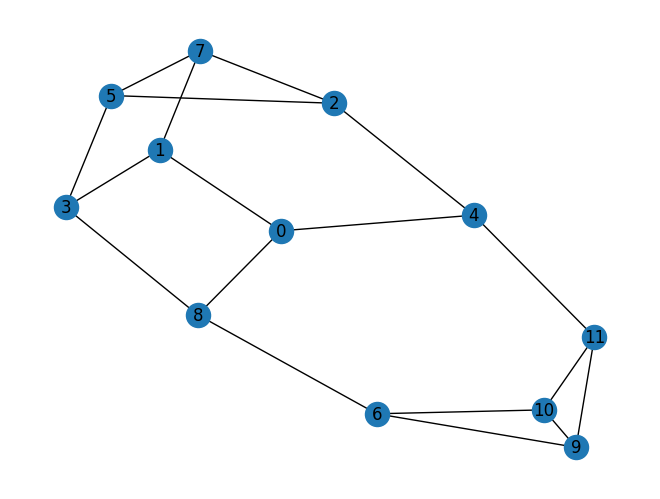

In [100]:
graph = nx.random_regular_graph(3, 12)
nx.draw(graph, with_labels=True)

## QRAO ハミルトニアンの作成

ここからは、QRAO のための緩和ハミルトニアンを作成する。

まずは、`jijmodeling_transpiler` を用いて `compiled_instance` を作成する。

In [ ]:
compiled_instance = jmt.compile_model(problem, {"E": list(graph.edges), "V": len(graph.nodes)})

次に、`QRAC31Converter` を用いて緩和ハミルトニアンを作成する。

In [ ]:
# コンパイル済みの最適化問題インスタンスで初期化する
qrao_converter = QRAC31Converter(compiled_instance, normalize_model=False)

# 緩和ハミルトニアンを生成
qrao31_hamiltonian = qrao_converter.get_cost_hamiltonian()
qrao31_hamiltonian

Hamiltonian((Z0, Z1): 1.5, (Z0, Z2): 1.5, (Z0, X2): 1.5, (Z1, X2): 1.5, (Z1, Z2): 1.5, (X0, X1): 1.5, (X0, Y1): 1.5, (X0, Z3): 1.5, (Y0, X1): 1.5, (X1, Y2): 1.5, (Y2, Z3): 1.5, (Y2, X3): 1.5, (Z2, Z3): 1.5, (Y1, Z4): 1.5, (Y0, Z4): 1.5, (X3, Z4): 1.5, (Y1, X2): 1.5, (Y0, X3): 1.5)

## QRAO回路の可視化
VQEでQRAOを使うため、VQEのアンサッツを作成します。
`create_efficient_su2_circuit` を使ってシンプルなアンサッツを作成できます。

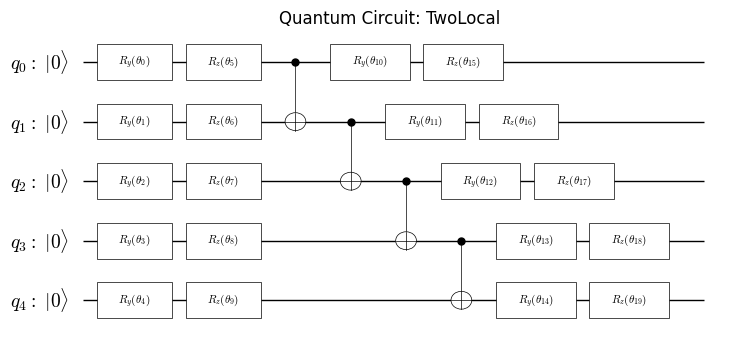

In [ ]:
ansatz = create_efficient_su2_circuit(qrao31_hamiltonian.num_qubits, rotation_blocks = ["ry", "rz"], reps = 1)
plot_quantum_circuit(ansatz)

## Qiskit を使ってQRAOを実行する
`QiskitTranspiler` を使うことで、上記の Qamomile のハミルトニアンと回路を Qiskit のハミルトニアンと回路に変換できます。

In [ ]:
qk_transpiler = qm_qk.QiskitTranspiler()
qk_ansatz = qk_transpiler.transpile_circuit(ansatz)
qk_qrao31_hamiltonian = qk_transpiler.transpile_hamiltonian(qrao31_hamiltonian)

QAOA ハミルトニアンは QAOAConverter を使って作成することもできます。


In [ ]:
qaoa_hamiltonian = QAOAConverter(compiled_instance, normalize_model=False).get_cost_hamiltonian()
qk_qaoa_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)

In [ ]:
print("The compression ratio of this problem is ", qaoa_hamiltonian.num_qubits / qrao31_hamiltonian.num_qubits)

The compression ratio of this problem is  2.4


## 緩和ハミルトニアンの基底状態を求める
緩和ハミルトニアンとVQEアンサッツが作成できたので、qiskitを用いてVQEを実行してみましょう。

In [ ]:
cost_history = []
def cost_estimator(param_values):
    estimator = qk_pr.StatevectorEstimator()
    job = estimator.run([(qk_ansatz, qk_qrao31_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data['evs']
    cost_history.append(cost)
    return cost

initial_params = np.random.uniform(0, np.pi, len(qk_ansatz.parameters))

# QAOA最適化を実行
result = minimize(
    cost_estimator,
    initial_params,
    method="COBYLA",
    options={"maxiter": 10000},
)
print(result)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -9.4649972737437
       x: [ 3.075e+00  1.912e+00 ... -3.416e-03  4.928e-05]
    nfev: 10000
   maxcv: 0.0


## 結果の可視化
最適値も対角化で確認し、プロットしてみましょう。

In [109]:
qrao_eigvals = eigsh(qk_qrao31_hamiltonian.to_matrix(), k=1, which='SA', return_eigenvectors=False)
qaoa_eigvals = eigsh(qk_qaoa_hamiltonian.to_matrix(), k=1, which='SA', return_eigenvectors=False)

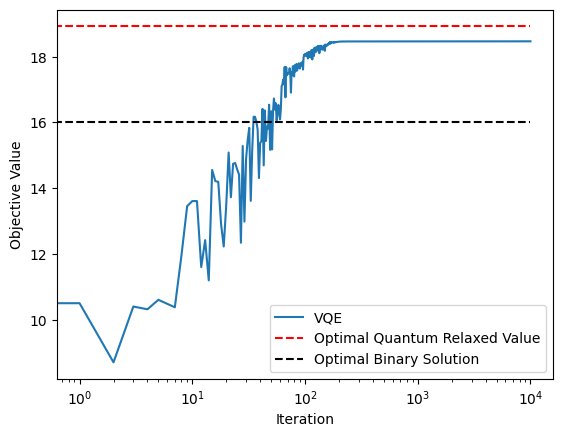

In [110]:
plt.plot(- (np.array(cost_history) + qrao31_hamiltonian.constant), label = "VQE")
plt.hlines(-(qrao_eigvals + qrao31_hamiltonian.constant), 0, len(cost_history), linestyles="dashed", label="Optimal Quantum Relaxed Value",colors="red")
plt.hlines(-(qaoa_eigvals + qrao31_hamiltonian.constant), 0, len(cost_history), linestyles="dashed", label="Optimal Binary Solution",colors="black")
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.xscale("log")
plt.legend(loc="lower right")
plt.show()

これは、[1] の図2と非常によく似ている。

## パウリラウンディング

前述のとおり、緩和ハミルトニアンの基底状態は古典的な最適解とは一致しない。  
したがって、量子状態から古典解を復元するためにラウンディングアルゴリズムが必要となる。

[1] では、Pauli Rounding と Magic State Rounding の2つのラウンディングアルゴリズムが提案されている。  
このチュートリアルでは、Pauli Rounding を用いて古典解を復号する。

`get_encoded_pauli_list` を使用することで、Pauli 演算子のリストを取得できる。  
このとき、Pauli 演算子の順序は対応するエンコード済み変数の順序に対応している。

In [ ]:
pauli_list = qrao_converter.get_encoded_pauli_list()
print(pauli_list)

[Hamiltonian((Z0,): 1.0), Hamiltonian((Z1,): 1.0), Hamiltonian((Z2,): 1.0), Hamiltonian((X2,): 1.0), Hamiltonian((X0,): 1.0), Hamiltonian((X1,): 1.0), Hamiltonian((Y1,): 1.0), Hamiltonian((Z3,): 1.0), Hamiltonian((Y0,): 1.0), Hamiltonian((Y2,): 1.0), Hamiltonian((X3,): 1.0), Hamiltonian((Z4,): 1.0)]


この演算子の期待値を計算できます。

In [ ]:
qiskit_pauli_list = [qk_transpiler.transpile_hamiltonian(pauli) for pauli in pauli_list]

estimator = qk_pr.StatevectorEstimator()
job = estimator.run([(qk_ansatz, pauli, result.x) for pauli in qiskit_pauli_list])
rounded_values = [np.sign(_res.data['evs']) for _res in job.result()]
binary_values = [(1 - _val) // 2 for _val in rounded_values]
binary_values

[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0]

このバイナリ変数の結果を `decode_bits_to_sampleset` を使って `sampleset` に変換できます。

In [ ]:
bitsample = qm.BitsSample(1,binary_values)
sampleset = qrao_converter.decode_bits_to_sampleset(qm.BitsSampleSet([bitsample]))

## 解のプロット
最後に、結果が得られました！
それでは、可視化してみよう。

In [ ]:
def get_edge_colors(
    graph, cut_solution, in_cut_color="r", not_in_cut_color="b"
):
    cut_set_1 = [node[0] for node, value in cut_solution.items() if value == 1.0]
    cut_set_2 = [node for node in graph.nodes() if node not in cut_set_1]

    edge_colors = []
    for u, v, _ in graph.edges(data=True):
        if (u in cut_set_1 and v in cut_set_2) or (u in cut_set_2 and v in cut_set_1):
            edge_colors.append(in_cut_color)
        else:
            edge_colors.append(not_in_cut_color)
    node_colors = ["#2696EB" if node in cut_set_1 else "#EA9b26" for node in graph.nodes()]
    return edge_colors, node_colors

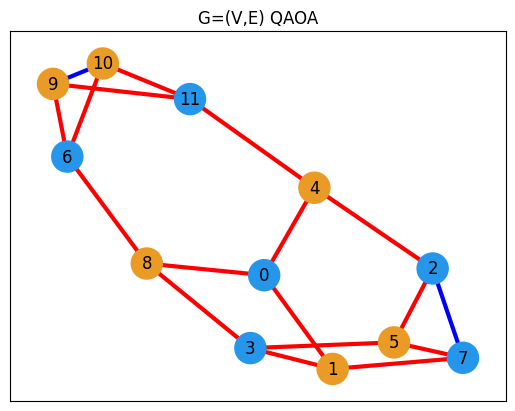

In [ ]:
best_values = sampleset[0].var_values["x"].values
edge_colors, node_colors = get_edge_colors(graph, best_values)
edge_labels = nx.get_edge_attributes(graph, "weight")

plt.title("G=(V,E) QAOA")
plt.plot(figsize=(5, 4))
nx.draw_networkx(
    graph,
    node_size=500,
    width=3,
    with_labels=True,
    edge_color=edge_colors,
    node_color=node_colors,
)


# References
[1] Bryce Fuller, Charles Hadfield, Jennifer R. Glick, Takashi Imamichi, Toshinari Itoko, Richard J. Thompson, Yang Jiao, Marna M. Kagele, Adriana W. Blom-Schieber, Rudy Raymond, and Antonio Mezzacapo. Approximate solutions of combinatorial problems via quantum relaxations. IEEE Transactions on Quantum Engineering, 5():1–15, 2024. doi:10.1109/TQE.2024.3421294.

[2] Kosei Teramoto, Rudy Raymond, Eyuri Wakakuwa, and Hiroshi Imai. Quantum-relaxation based optimization algorithms: theoretical extensions. 2023. URL: https://arxiv.org/abs/2302.09481, arXiv:2302.09481.